# Left Side

x values where y=0.5: [2.77585291 4.74427283 5.0637973 ]
1st Peak at x = 3.19135, y = 2.96951
2nd Peak at x = 6.01827, y = 1.55362
3rd Peak at x = 9.71342, y = 1.09171
1st minimum at x = 4.89840, y = 0.48038
2nd minimum at x = 8.21660, y = 0.91410


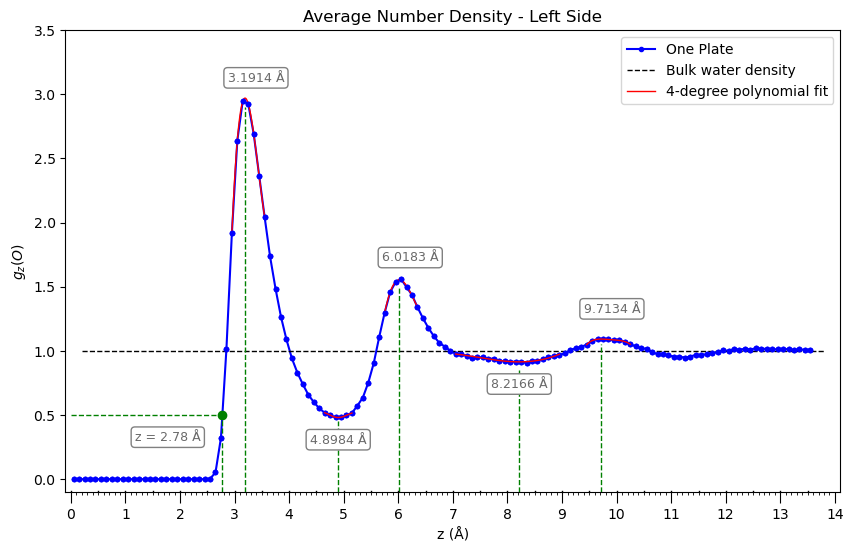

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/gibbs/joecruz/wu_hydroplates/one_plate/gzInterference/leftSide.dat'
output_path = '/gibbs/arghavan/hp-results-pc/'

data = np.loadtxt(input_file)

number_of_voxels = 170*170

x = data[:, 0]
number_density = data[:, 1]/number_of_voxels

# np.savetxt(f'{output_path}gZ-one-plate-300K-leftSide.dat', 
#         np.column_stack((x, number_density)), 
#         header='x (Angstrom)    g_z(O)', 
#         comments='')

half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)


plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=0.2, xmax=13.8, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[0], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[0], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[0], [half_density], color='green', zorder=3)


plt.text(x_for_half[0] - 1, 0.3, f"z = {x_for_half[0]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# --------------------------- Polynomial Fit ---------------------------


# ------------------------------- Find First Peak --------------------------------
mask = (x >= 2.9) & (x <= 3.6)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv() # Derivative of polynomial
x_candidates = dpoly.r # Roots of the derivative are candidate maxima/minima
x_candidates = x_candidates[np.isreal(x_candidates)].real # Keep only real roots within the range
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) # Evaluate polynomial at candidates to find the maximum
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"1st Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1, label=f'{degree}-degree polynomial fit')
# plt.plot(x_max, y_max+0.02, 'k.',linewidth=1, label=f'peak at {x_max:.4f} Å')
plt.vlines(x=x_max, ymin=-0.1, ymax=2.9, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 3.1, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Peak --------------------------------
mask = (x >= 5.7) & (x <= 6.4)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)

dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real 
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"2nd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.5, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.7, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------------- Find Third Peak --------------------------------
mask = (x >= 9.4) & (x <= 10.3)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"3rd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.05, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.3, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find First Minimum --------------------------------
mask = (x >= 4.6) & (x <= 5.24)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"1st minimum at x = {x_min:.5f}, y = {y_min:.5f}")

# --- Plot ---
x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.45, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Minimum --------------------------------
mask = (x >= 7.0) & (x <= 9.0)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"2nd minimum at x = {x_min:.5f}, y = {y_min:.5f}")

x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.85, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------- Plot Customization -------------------------

plt.title('Average Number Density - Left Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-0.1,14.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


medium_ticks = np.arange(0, 14, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True)  

small_ticks = np.arange(0, 14.1, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

# Adjust styles
plt.tick_params(axis='x', which='major', length=8)   
plt.tick_params(axis='x', which='minor', length=2)   

for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

plot_path = f"{output_path}/one-plate/plots/"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

plt.savefig(f'{plot_path}/all-peaks-left-side.png', dpi=600)



x values where y=0.5: [2.77585291 4.74427283 5.0637973 ]
1st Peak at x = 3.19135, y = 2.96951
2nd Peak at x = 6.01827, y = 1.55362
3rd Peak at x = 9.71342, y = 1.09171
1st minimum at x = 4.89840, y = 0.48038
2nd minimum at x = 8.21660, y = 0.91410


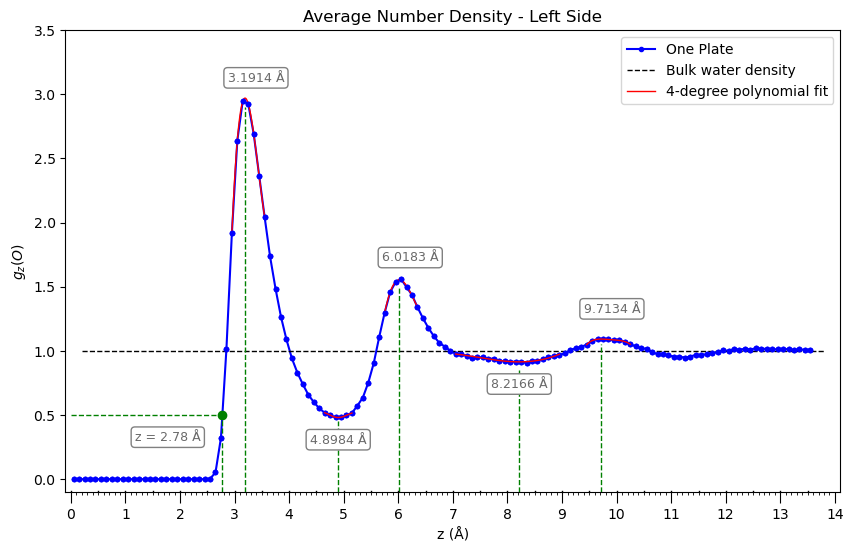

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
# output_path = '/Users/arghavan/lab/hp-results-pc/'

data = np.loadtxt(input_file, skiprows=1)


x = data[:, 0]
number_density = data[:, 1]

# np.savetxt(f'{output_path}gZ-one-plate-300K-leftSide.dat', 
#         np.column_stack((x, number_density)), 
#         header='x (Angstrom)    g_z(O)', 
#         comments='')

half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)


plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=0.2, xmax=13.8, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[0], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[0], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[0], [half_density], color='green', zorder=3)


plt.text(x_for_half[0] - 1, 0.3, f"z = {x_for_half[0]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# --------------------------- Polynomial Fit ---------------------------


# ------------------------------- Find First Peak --------------------------------
mask = (x >= 2.9) & (x <= 3.6)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv() # Derivative of polynomial
x_candidates = dpoly.r # Roots of the derivative are candidate maxima/minima
x_candidates = x_candidates[np.isreal(x_candidates)].real # Keep only real roots within the range
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) # Evaluate polynomial at candidates to find the maximum
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"1st Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1, label=f'{degree}-degree polynomial fit')
# plt.plot(x_max, y_max+0.02, 'k.',linewidth=1, label=f'peak at {x_max:.4f} Å')
plt.vlines(x=x_max, ymin=-0.1, ymax=2.9, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 3.1, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Peak --------------------------------
mask = (x >= 5.7) & (x <= 6.4)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)

dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real 
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"2nd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.5, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.7, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------------- Find Third Peak --------------------------------
mask = (x >= 9.4) & (x <= 10.3)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"3rd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.05, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.3, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find First Minimum --------------------------------
mask = (x >= 4.6) & (x <= 5.24)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"1st minimum at x = {x_min:.5f}, y = {y_min:.5f}")

# --- Plot ---
x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.45, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Minimum --------------------------------
mask = (x >= 7.0) & (x <= 9.0)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"2nd minimum at x = {x_min:.5f}, y = {y_min:.5f}")

x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.85, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------- Plot Customization -------------------------

plt.title('Average Number Density - Left Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-0.1,14.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


medium_ticks = np.arange(0, 14, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True)  

small_ticks = np.arange(0, 14.1, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

# Adjust styles
plt.tick_params(axis='x', which='major', length=8)   
plt.tick_params(axis='x', which='minor', length=2)   

for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

# plot_path = f"{output_path}/one-plate/plots/"
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)

# plt.savefig(f'{plot_path}/all-peaks-left-side.png', dpi=600)



9.2097

# Right Side

x values where y=0.5: [-5.08596871 -4.76376037 -2.77551486]
1st Peak at x = -3.19534, y = 2.97699
2nd Peak at x = -6.02797, y = 1.54713
3rd Peak at x = -9.86446, y = 1.08664
1st minimum at x = -4.93889, y = 0.48078
2nd minimum at x = -8.22831, y = 0.91391


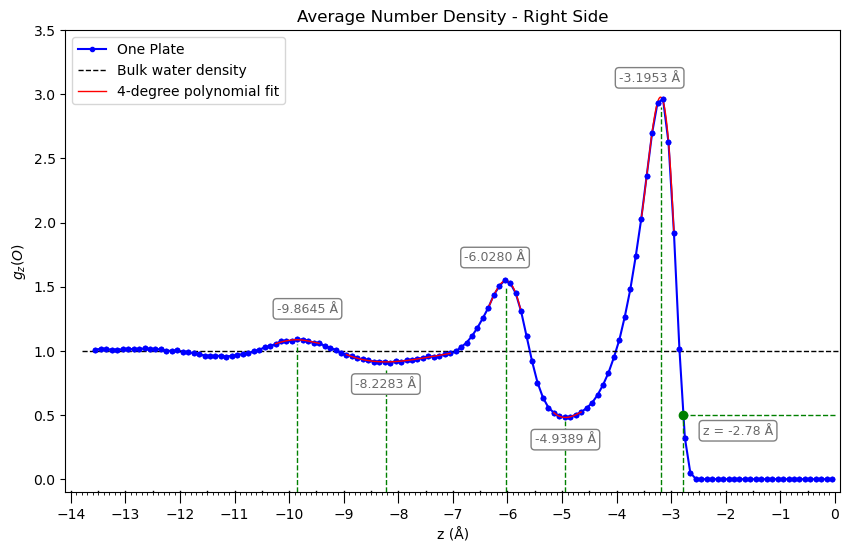

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/gibbs/joecruz/wu_hydroplates/one_plate/gzInterference/rightSide.dat'
output_path = '/gibbs/arghavan/hp-results-pc/one-plate/plots/'

data = np.loadtxt(input_file)

number_of_voxels = 170*170

x = data[:, 0]
number_density = data[:, 1]/number_of_voxels



half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)




plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=-13.8, xmax=0.2, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[-1], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[-1], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[-1], [half_density], color='green', zorder=3)


plt.text(x_for_half[-1] + 1, 0.35, f"z = {x_for_half[-1]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# --------------------------- Polynomial Fit ---------------------------


# ------------------------------- Find First Peak --------------------------------
mask = (x >= -3.6) & (x <= -2.9)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv() 
x_candidates = dpoly.r # Roots of the derivative are candidate maxima/minima
x_candidates = x_candidates[np.isreal(x_candidates)].real # Keep only real roots within the range
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) # Evaluate polynomial at candidates to find the maximum
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"1st Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1, label=f'{degree}-degree polynomial fit')
# plt.plot(x_max, y_max+0.02, 'k.',linewidth=1, label=f'peak at {x_max:.4f} Å')
plt.vlines(x=x_max, ymin=-0.1, ymax=2.9, color='green', linestyle='--', linewidth=1)
plt.text(x_max - 0.2, 3.1, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Peak --------------------------------
mask = (x >= -6.4) & (x <= -5.7)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)

dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real 
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"2nd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.5, color='green', linestyle='--', linewidth=1)
plt.text(x_max - 0.2, 1.7, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------------- Find Third Peak --------------------------------
mask = (x >= -10.3) & (x <= -9.4)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"3rd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.05, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.3, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find First Minimum --------------------------------
mask = (x >= -5.24) & (x <= -4.6)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"1st minimum at x = {x_min:.5f}, y = {y_min:.5f}")

# --- Plot ---
x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.45, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Minimum --------------------------------
mask = (x >= -9.0) & (x <= -7.0)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 3
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"2nd minimum at x = {x_min:.5f}, y = {y_min:.5f}")

x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.85, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# -------------------------

plt.title('Average Number Density - Right Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-14.1,0.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

medium_ticks = np.arange(-14, 0, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True) 

small_ticks = np.arange(-14, 0, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

plt.tick_params(axis='x', which='major', length=8)   
plt.tick_params(axis='x', which='minor', length=2)   
for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

plot_path = f"{output_path}/one-plate/plots/"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

plt.savefig(f'{plot_path}/all-peaks-right-side.png', dpi=600)



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os

input_file = '/Users/arghavan/lab/hp-results-pc/one-plate/gZ-one-plate-300K-leftSide.dat'
# output_path = '/gibbs/arghavan/hp-results-pc/one-plate/plots/'

data = np.loadtxt(input_file)

# number_of_voxels = 170*170

x = data[:, 0]
# number_density = data[:, 1]/number_of_voxels
number_density = data[:, 1]


half_density = 0.5
idx = np.where(np.diff(np.sign(number_density - half_density)))[0]
x_for_half = x[idx] + (half_density - number_density[idx]) * (x[idx+1] - x[idx]) / (number_density[idx+1] - number_density[idx])

print("x values where y=0.5:", x_for_half)




plt.figure(figsize=(10, 6))
plt.plot(x, number_density, 'bo-', markersize=3, label='One Plate', zorder=2)

plt.hlines(y=1.00, xmin=-13.8, xmax=0.2, color='black', linestyle='--', linewidth=1, label='Bulk water density')
plt.hlines(y=0.5, xmin=0, xmax=x_for_half[-1], color='green', linestyle='--', linewidth=1)

plt.vlines(x=x_for_half[-1], ymin=-0.1, ymax=0.5, color='green', linestyle='--', linewidth=1)

plt.scatter(x_for_half[-1], [half_density], color='green', zorder=3)


plt.text(x_for_half[-1] + 1, 0.35, f"z = {x_for_half[-1]:.2f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# --------------------------- Polynomial Fit ---------------------------


# ------------------------------- Find First Peak --------------------------------
mask = (x >= -3.6) & (x <= -2.9)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv() 
x_candidates = dpoly.r # Roots of the derivative are candidate maxima/minima
x_candidates = x_candidates[np.isreal(x_candidates)].real # Keep only real roots within the range
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) # Evaluate polynomial at candidates to find the maximum
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"1st Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1, label=f'{degree}-degree polynomial fit')
# plt.plot(x_max, y_max+0.02, 'k.',linewidth=1, label=f'peak at {x_max:.4f} Å')
plt.vlines(x=x_max, ymin=-0.1, ymax=2.9, color='green', linestyle='--', linewidth=1)
plt.text(x_max - 0.2, 3.1, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Peak --------------------------------
mask = (x >= -6.4) & (x <= -5.7)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)

dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real 
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"2nd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

# --- Plot ---
x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.5, color='green', linestyle='--', linewidth=1)
plt.text(x_max - 0.2, 1.7, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# ------------------------------- Find Third Peak --------------------------------
mask = (x >= -10.3) & (x <= -9.4)
x_peak = x[mask]
numdens_peak = number_density[mask]


degree = 4
coeffs = np.polyfit(x_peak, numdens_peak, deg=degree)
poly = np.poly1d(coeffs)


dpoly = poly.deriv()
x_candidates = dpoly.r 
x_candidates = x_candidates[np.isreal(x_candidates)].real
x_candidates = x_candidates[(x_candidates >= x_peak.min()) & (x_candidates <= x_peak.max())]

numdens_candidates = poly(x_candidates) 
i_max = np.argmax(numdens_candidates)
x_max = x_candidates[i_max]
y_max = numdens_candidates[i_max]

print(f"3rd Peak at x = {x_max:.5f}, y = {y_max:.5f}")

x_fit = np.linspace(x_peak.min(), x_peak.max(), 200)
plt.plot(x, number_density, 'b.')
plt.plot(x_fit, poly(x_fit), 'r-',linewidth=1)
plt.vlines(x=x_max, ymin=-0.1, ymax=1.05, color='green', linestyle='--', linewidth=1)
plt.text(x_max + 0.2, 1.3, f"{x_max:.4f} Å", ha='center', fontsize=9, color='dimgrey',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find First Minimum --------------------------------
mask = (x >= -5.24) & (x <= -4.6)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 4
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"1st minimum at x = {x_min:.5f}, y = {y_min:.5f}")

# --- Plot ---
x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.45, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# ------------------------------- Find Second Minimum --------------------------------
mask = (x >= -9.0) & (x <= -7.0)
x_min_region = x[mask]
numdens_min_region = number_density[mask]

degree = 3
coeffs_min = np.polyfit(x_min_region, numdens_min_region, deg=degree)
poly_min = np.poly1d(coeffs_min)

dpoly_min = poly_min.deriv()
x_candidates_min = dpoly_min.r
x_candidates_min = x_candidates_min[np.isreal(x_candidates_min)].real
x_candidates_min = x_candidates_min[(x_candidates_min >= x_min_region.min()) & (x_candidates_min <= x_min_region.max())]

numdens_candidates_min = poly_min(x_candidates_min)
i_min = np.argmin(numdens_candidates_min) 
x_min = x_candidates_min[i_min]
y_min = numdens_candidates_min[i_min]

print(f"2nd minimum at x = {x_min:.5f}, y = {y_min:.5f}")

x_fit_min = np.linspace(x_min_region.min(), x_min_region.max(), 200)
plt.plot(x_fit_min, poly_min(x_fit_min), 'r-', linewidth=1)
plt.vlines(x=x_min, ymin=-0.1, ymax=0.85, color='green', linestyle='--', linewidth=1)
plt.text(x_min, y_min - 0.2, f"{x_min:.4f} Å", ha='center', fontsize=9, color='dimgrey',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


# -------------------------

plt.title('Average Number Density - Right Side')
plt.xlabel('z (Å)')
plt.ylabel(r'$g_z(O)$')
plt.ylim(-0.1, 3.5)
plt.xlim(-14.1,0.1)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

medium_ticks = np.arange(-14, 0, 0.5)
plt.gca().set_xticks(medium_ticks, minor=True) 

small_ticks = np.arange(-14, 0, 0.1)
plt.gca().set_xticks(small_ticks, minor=True)

plt.tick_params(axis='x', which='major', length=8)   
plt.tick_params(axis='x', which='minor', length=2)   
for t in medium_ticks:
    plt.gca().axvline(t, ymin=0, ymax=0.003, color='k', lw=1)


plt.legend()

plot_path = f"{output_path}/one-plate/plots/"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)

plt.savefig(f'{plot_path}/all-peaks-right-side.png', dpi=600)

